# GA DSI 26: Project 2 - Ames Housing Data and Kaggle Challenge
***

## Project Notebooks organisation  
- Notebook 1 - Data Cleaning, EDA and Data Visualisation
- Notebook 2 - Feature Engineering  
- **Notebook 3 - Pre-processing, Model Benchmarks, Production Model and Kaggle Submission (current notebook)**
***

## Introduction

In this notebook, I will be carrying out pre-processing to prepare the data for modelling then carrying out model benchmarks via cross validation. After which, i will be deciding on a production model based on the cross validation scores and picking the top 30 coefficients of that model and re-run the model to see if a better score is obtained. Lastly, i will be using some of the models on the Kaggle test set and uploading to Kaggle for scoring. 

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data

train_eng = pd.read_csv('../datasets/train_eng.csv')

In [3]:
# remove unnamed column
train_eng = train_eng.iloc[:, 1:]

# convert 'ms_subclass' column to str after importing
train_eng['ms_subclass'] = train_eng['ms_subclass'].astype(str);

In [4]:
train_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   1st_flr_sf      2042 non-null   int64  
 1   bsmt_exposure   2042 non-null   object 
 2   bsmt_full_bath  2042 non-null   float64
 3   bsmt_qual       2042 non-null   int64  
 4   bsmtfin_type_1  2042 non-null   int64  
 5   exter_qual      2042 non-null   int64  
 6   fireplace_qu    2042 non-null   int64  
 7   fireplaces      2042 non-null   int64  
 8   foundation      2042 non-null   object 
 9   full_bath       2042 non-null   int64  
 10  garage_area     2042 non-null   float64
 11  garage_finish   2042 non-null   object 
 12  garage_type     2042 non-null   object 
 13  garage_yr_blt   2042 non-null   float64
 14  gr_liv_area     2042 non-null   int64  
 15  half_bath       2042 non-null   int64  
 16  heating_qc      2042 non-null   int64  
 17  house_style     2042 non-null   o

## Pre-processing
***

### Get dummies for train data

After get dummies, there are 117 features in the dummy dataset.

In [5]:
train_dummies = pd.get_dummies(train_eng, drop_first = True)

In [6]:
train_dummies.shape

(2042, 117)

### Create feature matrix (X) and target vector (y)

The feature matrix (X) is every column other than the saleprice which is our target vector (y).

In [7]:
X = train_dummies.loc[:, train_dummies.columns != 'saleprice']
y = train_dummies['saleprice']

print(X.shape)
print(y.shape)

(2042, 116)
(2042,)


### Train-test split for train data

As there are 2042 rows in the train dataset, the dataset is not particularly large hence I have decided to go with a split of 70% for training data set and 30% for testing dataset. Instead of using ```X_test``` and ```y_test```, I shall be using ```X_val``` and ```y_val``` instead so as not to confused with the test dataset provided

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.7, random_state = 42)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(1429, 116)
(613, 116)
(1429,)
(613,)


### Scaling using StandardScaler

I will be using StandardScaler as there are multiple colunmns in the X dataset that are on different scales.

In [9]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)
X_val_ss = ss.transform(X_val)

## Model Preperation
***

### Hyperparameter Tuning

I will be trying to find the optimal alpha for both Ridge and Lasso and rerunning the model again to check for the new scores.

#### Optimal Ridge alpha α

In [10]:
# set up a list of ridge alpha to check
r_alphas = np.logspace(0, 5, 200)

# Cross-validate over our list of ridge alphas.
ridge_cv = RidgeCV(alphas = r_alphas, cv = 10)
ridge_cv = ridge_cv.fit(X_train_ss, y_train)

print('Optimal Ridge Alpha: ', ridge_cv.alpha_)
print('Best Ridge R2: ', ridge_cv.score(X_train_ss, y_train))

Optimal Ridge Alpha:  19.116440753857027
Best Ridge R2:  0.9185811022861159


#### Optimal Lasso alpha α

In [11]:
lasso_cv = LassoCV(n_alphas = 500, cv = 10)
lasso_cv = lasso_cv.fit(X_train_ss, y_train)

print('Optimal Lasso alpha: ', lasso_cv.alpha_)
print('Best Lasso R2: ', lasso_cv.score(X_train_ss, y_train))

Optimal Lasso alpha:  125.65240473439307
Best Lasso R2:  0.9175112792621446


### Instantiate the models (DummyRegressor, Linear Regression, Lasso and Ridge) 

In [12]:
dummy_reg = DummyRegressor() # default is using mean
lr = LinearRegression()
ridge = Ridge(alpha = ridge_cv.alpha_)
lasso = Lasso(alpha = lasso_cv.alpha_)

### Cross validation 

I will be using 3 models (Linear Regression, Ridge and Lasso) and testing them using cross validation on the training data

In [13]:
def cross_val(model, x, y):
    """Function to calculate cross_val_score"""
    rmse = -cross_val_score(model, x, y, cv = 10, scoring = 'neg_root_mean_squared_error')
    r2 = cross_val_score(model, x, y, cv = 10)
    print(model)
    print(f"Mean CV R2: {r2.mean()}\nMean CV RMSE: {rmse.mean()}\nStd CV R2 : {np.std(r2)}\nStd CV RMSE: {np.std(rmse)}\n")

In [14]:
# cross validation with standard scaler for X data

cross_val(dummy_reg, X_train_ss, y_train)
cross_val(lr, X_train_ss, y_train)
cross_val(ridge, X_train_ss, y_train)
cross_val(lasso, X_train_ss, y_train)

DummyRegressor()
Mean CV R2: -0.004180595773010332
Mean CV RMSE: 80055.03180720672
Std CV R2 : 0.003841399043741929
Std CV RMSE: 8434.48491404218

LinearRegression()
Mean CV R2: -6.836541447059624e+22
Mean CV RMSE: 9942006741901734.0
Std CV R2 : 1.5612393170847374e+23
Std CV RMSE: 1.568466918336284e+16

Ridge(alpha=19.116440753857027)
Mean CV R2: 0.8959742659938115
Mean CV RMSE: 25598.708289843584
Std CV R2 : 0.02131970223683307
Std CV RMSE: 3292.6469586946528

Lasso(alpha=125.65240473439307)
Mean CV R2: 0.8971143842726853
Mean CV RMSE: 25475.83785958947
Std CV R2 : 0.020671108810084937
Std CV RMSE: 3326.956553758647



| Cross Validation Scores           | Mean CV R2 Score |    Mean CV RMSE   |
|-----------------------------------|:----------------:|:-----------------:|
| Dummy Regressor (Strategy: mean)  |    -0.00418059   |      80055.03     |
| Linear Regression                 |   -6.836541e+22  |     9.942006e+15  |
| Ridge (alpha = 19.1164)           |     0.895974     |      25598.70     |
| Lasso (alpha = 125.6524)          |     0.897114     |      25475.83     |

In total, four different models were tested (including the baseline model) using cross validation on the data and the R2 scores and RMSE are shown in the table above. 

As it can be seen from the result table, the ordinary linear regression model is performing very badly with a large Mean CV R2 score which should indicate that this is a poor fit to this dataset which is not entirely surprising with the large number of features used and possible complex relationships between these features, including multicollinearity. The regularised models are performing better than the ordinary linear regression model in which the best regularised model seems to be the Ridge model compared to Lasso. However, as the scores are very close to each other. 

As a next step, I will carry out model evaluation to confirm the scores with the train and test dataset,

## Model Evaluation
***

In [15]:
def rmse(y_test, y_pred):
    """Function to calculate rmse score"""
    return np.sqrt(mean_squared_error(y_test, y_pred))

def model_eval(model, X_train, X_val, y_train, y_val):
    "Function to fit and generate the train and test scores and RMSE"
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    
    print(f'{model}\nR2 train score: {model.score(X_train, y_train)}\nR2 test score: {model.score(X_val, y_val)}\nRMSE: {rmse(y_val, pred)}\n')

#### Fit models, get train and test scores

In [16]:
model_eval(dummy_reg, X_train_ss, X_val_ss, y_train, y_val)
model_eval(lr, X_train_ss, X_val_ss, y_train, y_val)
model_eval(ridge, X_train_ss, X_val_ss, y_train, y_val)
model_eval(lasso, X_train_ss, X_val_ss, y_train, y_val)

DummyRegressor()
R2 train score: 0.0
R2 test score: -0.0012779576065851117
RMSE: 76412.97477239647

LinearRegression()
R2 train score: 0.9194024451675047
R2 test score: 0.8865871664415672
RMSE: 25717.034055742613

Ridge(alpha=19.116440753857027)
R2 train score: 0.9185811022861159
R2 test score: 0.8877340344449347
RMSE: 25586.674089624747

Lasso(alpha=125.65240473439307)
R2 train score: 0.9175112792621446
R2 test score: 0.8875865872694767
RMSE: 25603.47100969911



| Model Evaluation                  | R2 Train Score | R2 Test Score |   RMSE   |
|-----------------------------------|:--------------:|:-------------:|:--------:|
| Dummy Regressor (Strategy: mean)  |       0.0      |    -0.00127   | 76412.97 |
| Linear Regression                 |    0.919402    |    0.886587   | 25717.03 |
| Ridge (alpha = 19.1164)           |    0.918581    |    0.887734   | 25586.67 |
| Lasso (alpha = 125.6524)          |    0.917511    |    0.887586   | 25603.47 |

As seen from table of results above, for the Linear Regressions, Ridge and Lasso models, there are differences in the train and test scores which could indicate some overfitting of the models. For the best performing model by a smaller extent is the Ridge model when comparing the train scores, test scores and the RMSE values which is the lowest. I have also decided to pick Ridge over Lasso as Laaso will tend to randomly leave one variable when there are two or more highly collinear variables. This not good for my interpretation of data as I am looking for the features that will affect sales price hence it will be better to use Ridge as it only reduces the coefficients close to zero but does not carry out any feature selection. This will allow me to sort the Ridge coefficients and pick the top 30 coefficients to ensure an easy to interpret production model.

Compared to an ordinary linear regression, Ridge and Lasso applies a penalty term (L2 and L1 regularization technique respectively) which minimises the coefficients, thereby shrinking the coefficients of the least important features. It helps to reduces the bias compared to a linear regression, by reducing the number of coefficients and enabling the fitting of a more accurate regression line. 

As the features have been scaled prior to model evalaution, the coefficients in regularised regression models will be able to directly represent the importance of the feature in predicting the outcome. This allows one to select a subset of features to include in the final model which will be those that have the largest effect (both positive and negative) on `sale_price`. However, by choosing to go with a regularised regression model, they are slightly worse for interpretation than an ordinary linear model due to the lack of a direct relationship between features and the predictor because of the scaling that is done to the features.

## Production Model (Ridge Model)
***



### Feature Selection

For an easy to interpret production model, it is necessary to reduce the number of features even further than those selected by the regularised ridge model (the top model produced 116 non-zero coefficients). This was done using the coefficients obtained from the best model at the model evaluation stage. 

In [17]:
ridge_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})
ridge_coefs.shape

(116, 3)

In [18]:
ridge_coefs.sort_values(by = 'abs_coef')
top_thirty_features = ridge_coefs.sort_values(by = 'abs_coef', ascending = False).head(31)
top_thirty_features 

,variable,coef,abs_coef
10,gr_liv_area,20549.114000,20549.114000
19,overall_qual,13398.277462,13398.277462
62,ms_subclass_20,10695.686315,10695.686315
20,total_bsmt_sf,9484.287763,9484.287763
103,neighborhood_StoneBr,6748.390370,6748.390370
8,garage_area,6642.998468,6642.998468
4,exter_qual,6506.978851,6506.978851
56,mas_vnr_type_None,6489.857099,6489.857099
67,ms_subclass_60,6413.462278,6413.462278
14,kitchen_qual,6167.676860,6167.676860


As the `neighborhood_GrnHill` row only got 2 values in the train set as observed during EDA, we will be taking the top 31 coefficients and dropping `neighborhood_GrnHill` from it.

In [19]:
top_thirty_features.drop(top_thirty_features[top_thirty_features['variable'] == 'neighborhood_GrnHill'].index, inplace = True)

In [20]:
# to check if the row has been dropped
top_thirty_features.shape

(30, 3)

In [21]:
# get the list of top thirty features
thirty_lst = top_thirty_features['variable'].to_list()
thirty_lst

['gr_liv_area',
 'overall_qual',
 'ms_subclass_20',
 'total_bsmt_sf',
 'neighborhood_StoneBr',
 'garage_area',
 'exter_qual',
 'mas_vnr_type_None',
 'ms_subclass_60',
 'kitchen_qual',
 'exterior_wood',
 'mas_vnr_area',
 'neighborhood_NridgHt',
 'bsmt_exposure_Gd',
 'age_sold',
 'ms_subclass_30',
 'roof_style_Hip',
 'exterior_vinyl',
 'garage_type_Detchd',
 'garage_type_Attchd',
 'bsmt_full_bath',
 'lot_area',
 'bsmt_qual',
 'mas_vnr_type_Stone',
 'garage_finish_RFn',
 'ms_subclass_50',
 'ms_zoning_FV',
 'bsmtfin_type_1',
 'ms_zoning_RL',
 'neighborhood_Edwards']

### Run the production model with the top 30 features

In [22]:
# Create the new feature matrix with only the top 30 features

X_pmodel = X.loc[:, thirty_lst] # slicing it from X as X has already been OHE and saleprice column removed
y_pmodel = train_dummies['saleprice']

print(X_pmodel.shape)
print(y_pmodel.shape)

(2042, 30)
(2042,)


In [23]:
# rerun train, test, split and the varaibles will not have the underscore to ensure it is not confused with the train test split done above

Xtrain, Xval, ytrain, yval = train_test_split(X_pmodel, y_pmodel, train_size = 0.7, random_state = 42)

print(Xtrain.shape)
print(Xval.shape)
print(ytrain.shape)
print(yval.shape)

(1429, 30)
(613, 30)
(1429,)
(613,)


In [24]:
# Scale the X data

Xtrain_ss = ss.fit_transform(Xtrain)
Xval_ss = ss.transform(Xval)

In [25]:
# set up a list of ridge alpha to check
r_alphas = np.logspace(0, 5, 200)

# Cross-validate over our list of ridge alphas.
ridgecv = RidgeCV(alphas = r_alphas, cv = 10)
ridgecv = ridgecv.fit(Xtrain_ss, ytrain)

print('Optimal Ridge Alpha: ', ridgecv.alpha_)
print('Best Ridge R2: ', ridgecv.score(Xtrain_ss, ytrain))

Optimal Ridge Alpha:  20.255019392306675
Best Ridge R2:  0.8998331624029349


In [26]:
ridge_pmodel = Ridge(alpha = ridgecv.alpha_)

In [27]:
cross_val(ridge_pmodel, Xtrain_ss, ytrain)

Ridge(alpha=20.255019392306675)
Mean CV R2: 0.8926963673612995
Mean CV RMSE: 25996.433107173954
Std CV R2 : 0.020713534213446586
Std CV RMSE: 3200.927405738433



In [28]:
ridge_pmodel.fit(Xtrain_ss, ytrain)
rid_pred = ridge_pmodel.predict(Xval_ss)

print(f'Ridge Production Model R2 test score: {ridge_pmodel.score(Xval_ss, yval)}')
print(f'Ridge Production Model  R2 RMSE score: {rmse(yval, rid_pred)}')

Ridge Production Model R2 test score: 0.8724486015289351
Ridge Production Model  R2 RMSE score: 27272.967293579073


#### Coefficients of production model

In [29]:
ridge_pmodel_coefs = pd.DataFrame({'variable':Xtrain.columns,
                            'coef':ridge_pmodel.coef_,
                            'abs_coef':np.abs(ridge_pmodel.coef_)})
ridge_pmodel_coefs.sort_values(by = 'abs_coef', ascending  = False, inplace = True)
ridge_pmodel_coefs

,variable,coef,abs_coef
0,gr_liv_area,26510.817141,26510.817141
1,overall_qual,15947.724209,15947.724209
6,exter_qual,7927.397367,7927.397367
13,bsmt_exposure_Gd,7215.053876,7215.053876
9,kitchen_qual,7092.876049,7092.876049
3,total_bsmt_sf,6916.518115,6916.518115
11,mas_vnr_area,6867.833492,6867.833492
12,neighborhood_NridgHt,6353.417921,6353.417921
4,neighborhood_StoneBr,6119.497826,6119.497826
5,garage_area,5911.000347,5911.000347


The production model coefficients table above would show their relative importance/influence on the model. 

As it is expected, the area features of a house that have been identified during EDA have a large impact on the `sale_price`.
- `gr_liv_area`: 1 unit increase will result in a USD 26,510 increase in `sale_price`
- `total_bsmt_sf`: 1 unit increase will result in a USD 6,916 increase in `sale_price`
- `garage_area`: 1 unit increase will result in a USD 5,911 increase in `sale_price`

In addition, the quality features will also affect `sale_price` to a large extent.
- `overall_qual`: 1 unit increase will result in a USD 15,947 increase in `sale_price`
- `exter_qual`: 1 unit increase will result in a USD 7,927 increase in `sale_price`
- `kitchen_qual`: 1 unit increase will result in a USD 7,092 increase in `sale_price`

There are features with negative coefficients that are impacting `sale_price` includes:
- `age_sold`: 1 unit increase will result in a USD 3,829 decrease in `sale_price`

Features that are also positively impacting the `sale_price` includes location (`neighborhood_StoneBr` - Stone Brook, `neighborhood_NridgHt` - Northridge Heights), building class (`ms_subclass_20` - 1-STORY 1946 & NEWER ALL STYLES, `ms_subclass_60` - 2-STORY 1946 & NEWER). 

Features that are negatively impacting the `sale_price` includes location (`neighborhood_Edwards` - Edwards), the exterior materials (`exterior_wood`, `exterior_vinyl`) and having a rough garage finish (`garage_finish_RFn`)

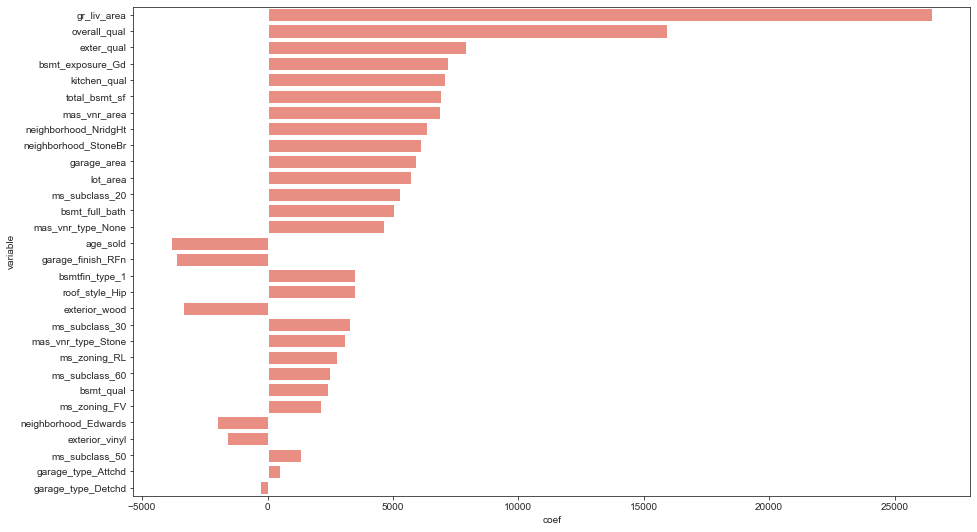

In [30]:
# plotting of bar chart of the coefficients.
plt.figure(figsize = (15,9))
sns.barplot(x = ridge_pmodel_coefs['coef'], y = ridge_pmodel_coefs['variable'], orient = 'h', color = 'salmon');


#### Production Model Score

|                          | R2 Test Score |   RMSE   |
|--------------------------|:-------------:|:--------:|
| Ridge                    |    0.887734   | 25586.67 |
| Ridge (with 30 features) |    0.872448   | 27272.96 |

The test score of the production model with 30 features at 0.872 is slightly worse than the test score of the original ridge model at 0.887 that was ran with 100+ features. This could be explain that the predictive power of the models will decrease when the number of features are reduced hence leading to a lower score with lesser features.


### Inferential plots of the production model

#### Predicted Values Distribution Plot

In the predicted values distribution plot below, it can be seen that the predicted y values and y valdiation values are generally of a linear relationship with a 1:1 relationship between the values with some exceptions in the outliers.

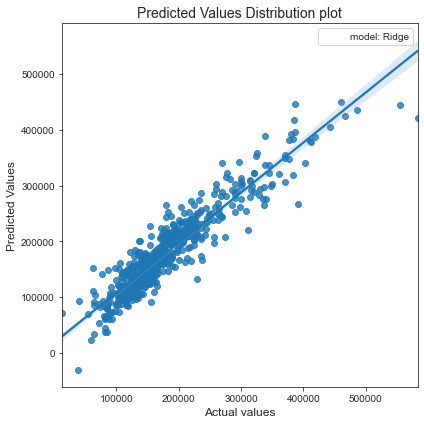

In [31]:
fig, ax = plt.subplots(figsize = (6.0, 6.0))
sns.regplot(yval, rid_pred)
ax.set_title('Predicted Values Distribution plot',fontsize = 14)
ax.set_xlabel('Actual values',fontsize = 12)
ax.set_ylabel('Predicted Values',fontsize = 12)
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls = "-", c = "r")
plt.plot([], [], ' ', label = "model: Ridge")
plt.legend()
plt.tight_layout()

#### Residual Distribution Plot

In the residual distribution plot above, it can be seen the residuals are scattered with a roughly equal distribution of variance of the residual points and the pattern is said to be unbiased and homoscedasticity. 

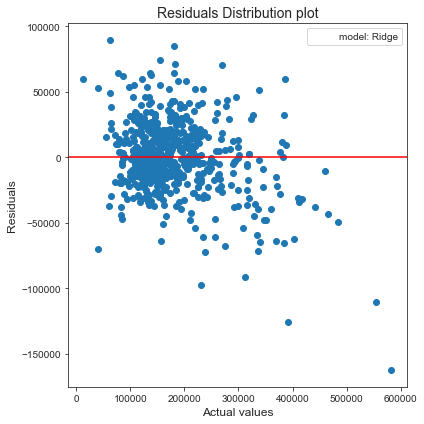

In [32]:
plt.figure(figsize = (6.0, 6.0))
plt.scatter(yval, (rid_pred - yval))
plt.axhline(0, linestyle='-', color='r')
plt.title('Residuals Distribution plot',fontsize=14)
plt.xlabel('Actual values',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.plot([], [], ' ', label="model: Ridge")
plt.legend()
plt.tight_layout()

## Conclusion and Recommendations

From the analysis done during this project, the model has identified the best model to use is Ridge model and from that initial model, I have obtained the top 30 features based on the Ridge coefficients. 

To answer the problem statement where I am a home owner in Ames who is considering to sell my house and want to improve some features to significantly improve the sale price, we can look at those features which have a large impact on the sale price. 

<u>**Some recommendations are:**</u>
1. Increase the area of the house in the ground living area, total basement area and in the garage area where these increases will help to increase the sale price. I can consider building an extension to the house if the space on the lot allows for it to help bring up the sale price basing on the assumption that the construction cost is not too expensive.

2. A simpler approach would be to improve the quality of of the house especially in the external areas and kitchen where an increase in these areas will result in a corresponding increase in sale price as well. Through improving these areas, it will also result in an increase in the overall quality of the house. 

3. If my house has a rough finish for the garage, it would be a good area to do some improvement works as a garage with rough finish will lead to a decrease in sales price. 

Some of the other features that have been identified that would impact sales price like building class or the neighbourhood that my house is in is not easily changed or rectify. These can be factors to consider when purchasing a house within the Ames area in the future. 

<u>**Limitations**</u>
1. The dataset only contains four years of sale price data from 2006 to 2010 and it is a pretty limiting dataset. From 2010 to present day, there could be changes or introduction of new features of houses that could impact sale price in this gap. For the data of year sold, the data captured is not over the entire year hence there could be missing information or trends relating to seasonality factors that is lacking. 

2. The dataset was only for Ames, Iowa, United States and the features could be unique to this region and the model might not be applicable to other regions or locations. An example would be the Fireplace feature. As Iowa is a mid-western state in United States, it's annual weather range is -11 to 28 degrees Celsius with an average of 20.4 degrees Celsius. Hence, the houses would have features like fireplaces which is appropriate for the weather but this might not be applicable to the southern states like Florida and Texas where the lowest temperature in those states are around 10 degrees Celsius. 

3. As the production model is only able to account for 87.2% of the variations in the sales price. This means that there are other features that would affect the remaining 12.8% of the variations. Some of this possible features could be the proximity of the houses to amenities, infrastructure like parks, schools, downtown area; and economic indicators.

4. Lastly, in real life, the sale prices could be affected by the psychology of the buyer where an example would be a buyer valuing a certain design of the house at a premium because it might be to their liking even though it might just be categorized as a point under exterior covering feature. This might not be able to be accounted for in any model as this psychology differs from individuals. 

***

## Kaggle Submission
***

### Pre-process the test data 

In [33]:
# import test result

test_eng = pd.read_csv('../datasets/test_eng.csv')
test_eng

,Unnamed: 0,id,ms_subclass,ms_zoning,lot_frontage,lot_area,lot_shape,lot_config,neighborhood,house_style,...,garage_type,garage_yr_blt,garage_finish,garage_area,wood_deck_sf,porch,pool,age_sold,remodelled,exterior
0,0,2658,190,RM,69.0,9142,0,Inside,OldTown,2Story,...,Detchd,1910.0,Unf,440,0,1,0,96,1,cemt_agg
1,1,2718,90,RL,68.0,9662,1,Inside,Sawyer,1Story,...,Attchd,1977.0,Fin,580,170,0,0,29,0,wood
2,2,2414,60,RL,58.0,17104,1,Inside,Gilbert,2Story,...,Attchd,2006.0,RFn,426,100,1,0,0,0,vinyl
3,3,1989,30,RM,60.0,8520,0,Inside,OldTown,1Story,...,Detchd,1935.0,Unf,480,0,1,0,84,1,wood
4,4,625,20,RL,68.0,9500,1,Inside,NAmes,1Story,...,Attchd,1963.0,RFn,514,0,1,0,46,0,wood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,873,1662,60,RL,80.0,8000,0,Inside,NWAmes,2Story,...,Attchd,1974.0,Unf,488,0,1,0,33,0,wood
874,874,1234,60,RL,90.0,14670,0,Inside,NAmes,2Story,...,Attchd,1966.0,RFn,480,0,1,0,42,1,vinyl
875,875,1373,20,RL,55.0,8250,0,Inside,Sawyer,1Story,...,Attchd,1968.0,Unf,322,0,1,0,40,0,wood
876,876,1672,20,RL,60.0,9000,0,FR2,NAmes,1Story,...,Detchd,1974.0,Unf,528,0,0,0,36,0,wood


In [34]:
# remove unnamed column
test_eng = test_eng.iloc[:, 1:]

# change the ms_subclass column to str type
test_eng['ms_subclass'] = test_eng['ms_subclass'].astype(str);

In [35]:
test_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              878 non-null    int64  
 1   ms_subclass     878 non-null    object 
 2   ms_zoning       878 non-null    object 
 3   lot_frontage    878 non-null    float64
 4   lot_area        878 non-null    int64  
 5   lot_shape       878 non-null    int64  
 6   lot_config      878 non-null    object 
 7   neighborhood    878 non-null    object 
 8   house_style     878 non-null    object 
 9   overall_qual    878 non-null    int64  
 10  roof_style      878 non-null    object 
 11  mas_vnr_type    878 non-null    object 
 12  mas_vnr_area    878 non-null    float64
 13  exter_qual      878 non-null    int64  
 14  foundation      878 non-null    object 
 15  bsmt_qual       878 non-null    int64  
 16  bsmt_exposure   878 non-null    object 
 17  bsmtfin_type_1  878 non-null    int

#### Get dummies for test data

In [36]:
# Get dummies for the test data set
test_dummies = pd.get_dummies(test_eng)

#### Slicing test data to only include the top features from production model

In [37]:
test_sliced = test_dummies[thirty_lst]
test_sliced.shape # to check on the number of columns


(878, 30)

In [38]:
# to check on the number of columns
Xtrain.shape

(1429, 30)

#### Scale the test data

In [39]:
test_ss = ss.transform(test_sliced)

### Predict the values from the test dataset (Ridge model with 30 features)

In [40]:
kaggle_pred = ridge_pmodel.predict(test_ss)
kaggle_pred.shape

(878,)

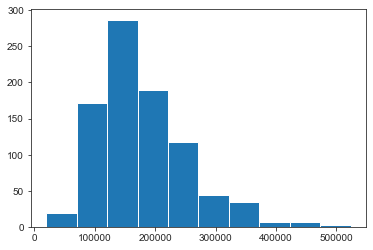

In [41]:
# to check and visualise the distribution of the results to ensure there is no issue
plt.hist(kaggle_pred);

#### Export data for Kaggle submission 

Create a new dataframe called ```export``` by joining back the ID column of the test data set for Kaggle submission.

In [42]:
# create a new dataframe call export with 2 columns with 1 being ID and the other being 'SalePrice'
export = pd.DataFrame({'Id': test_eng['id'], 'SalePrice': kaggle_pred}) 

export.shape # to check that there are 878 rows which is required for Kaggle submissions

(878, 2)

In [43]:
export.to_csv('../datasets/kaggle_results.csv', index =False)

#### Kaggle Score for Ridge model with 30 features

Kaggle private score: **24637**

### Predict the values from the test dataset (Alternative: Lasso model with 30 features)

In [44]:
lasso.coef_

array([-0.00000000e+00,  4.48504724e+03,  3.76113612e+03,  3.57371787e+03,
        6.59634873e+03,  1.58512726e+02,  1.99594110e+03,  1.64870701e+01,
        6.26703658e+03, -0.00000000e+00,  2.31279532e+04,  1.90047312e+03,
        1.88151869e+03,  2.58915213e+02,  6.15593165e+03,  4.28564041e+03,
        1.61371793e+03, -6.51478998e+02,  5.69441764e+03,  1.41448614e+04,
        9.56248014e+03,  2.09943762e+03, -0.00000000e+00, -1.31772342e+03,
       -4.92446968e+03,  1.31443164e+03,  5.53349252e+03, -1.25655697e+03,
       -2.62783913e+03,  2.92395986e+03, -6.35947656e+02,  2.12609335e+02,
        1.01972315e+03,  8.62709017e+02,  1.96037852e+01,  1.39331821e+03,
       -3.93587065e+03, -1.95844562e+03,  5.42123480e+02, -5.22097312e+02,
        0.00000000e+00, -4.15226044e+02,  9.63065307e+02,  1.42683403e+00,
       -0.00000000e+00, -2.18897303e+03,  1.85456575e+02, -0.00000000e+00,
       -0.00000000e+00,  3.84386416e+02,  0.00000000e+00,  1.65160253e+03,
       -3.37973236e+02, -

In [45]:
lasso_kaggle = LassoCV(n_alphas = 500, cv = 10)
lasso_kaggle = lasso_kaggle.fit(Xtrain_ss, ytrain)

print('Optimal Lasso alpha: ', lasso_kaggle.alpha_)
print('Best Lasso R2: ', lasso_kaggle.score(Xtrain_ss, ytrain))

Optimal Lasso alpha:  65.55497774231121
Best Lasso R2:  0.899874613843649


In [46]:
lasso_kmodel = Lasso(alpha = lasso_kaggle.alpha_)
lasso_kmodel.fit(Xtrain_ss, ytrain)

Lasso(alpha=65.55497774231121)

In [47]:
kaggle_lasso_pred = lasso_kmodel.predict(test_ss)
kaggle_lasso_pred.shape

(878,)

#### Export data for Kaggle submission (Lasso)

Create a new dataframe called ```export_lasso``` by joining back the ID column of the test data set for Kaggle submission.

In [48]:
# create a new dataframe call export with 2 columns with 1 being ID and the other being 'SalePrice'
export_lasso = pd.DataFrame({'Id': test_eng['id'], 'SalePrice': kaggle_lasso_pred}) 

export_lasso.shape # to check that there are 878 rows which is required for Kaggle submissions

(878, 2)

In [49]:
export_lasso.to_csv('../datasets/kaggle_results_lasso.csv', index =False)

#### Kaggle Score for Lasso model with 30 features

Kaggle private score: **24577**

### Kaggle Scores Conclusion

For the Kaggle Scores, it can be see that the Lasso model (RMSE: 24577) outperformed the Ridge model (RMSE: 24637) slightly for the top 30 features picked out to be used for the production model. 

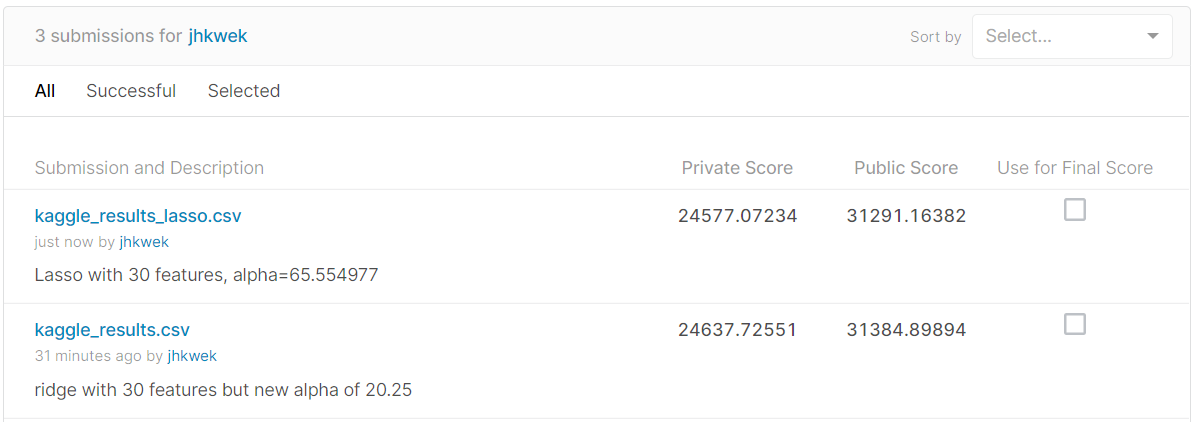